# Functional annotation of 16S amplicon data

In this script we will predict the functional/metabolic potential of the microbiome samples from 16S rRNA sequencing data using picrust. As picrust depends on an older version of QIIME, using it takes some flexibility. Sadly, Ancombc2 is also not available in this old version of QIIME which is why we also need our default QIIME environment (version 2025.10 or 2025.7). We will use Ancombc2 to investigate whether some pathways are differentially present depending on the timepoint while controlling for the longitudinal design of our samples.

<div class="alert alert-block alert-warning">
<b>⚠️ Warning ⚠️</b>

You may need to change some variables depending on the environment where this script is executed. This concers the path to the picrust2 conda environment which is different for JupyterHub and Euler/local machine. I have indicated which variable to use in the picrust-related cells.
</div>

This notebook can be exectuted on a SLURM cluster, when submitting the job from the `scripts/` directory:

```bash
sbatch --time=03:59:00 --cpus-per-task=8 --mem-per-cpu=5G --output=slurm-%j.out --error=slurm-%j.err --wrap="bash -c 'module load eth_proxy && source $HOME/.bashrc && conda activate microbEvolve && jupyter nbconvert --to notebook --execute ./04-2_functional_annotation.ipynb --output ./04-2_functional_annotation.ipynb'"
```

In [1]:
import os
import subprocess

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import seaborn as sns

# import qiime2
from qiime2 import Artifact

data_dir = "../data"
picrust_input_dir = f"{data_dir}/raw/picrust_input"
picrust_results_dir = f"{data_dir}/processed/picrust2_results"
os.makedirs(picrust_input_dir, exist_ok=True)
os.makedirs(picrust_results_dir, exist_ok=True)

plt.style.use("../presentation.mplstyle")
os.makedirs("../figures", exist_ok=True)

# Check if Source Sans Pro is available, only needed for presentation.mplstyle
fonts = [f.name for f in fm.fontManager.ttflist]
if "Source Sans Pro" not in fonts:
    plt.rcParams['font.family'] = 'sans-serif'
    print("Source Sans Pro not found, using default sans-serif font.")

%matplotlib inline

In [2]:
try:
    num_cpus = int(os.getenv('SLURM_CPUS_PER_TASK'))
except TypeError:
    num_cpus = os.cpu_count()

print(f"Number of CPUs available: {num_cpus}")

Number of CPUs available: 8


## Setup Steps

Working with the picrust QIIME plugin does not work seamlessly in our case, as the plugin is based on an older version of QIIME and is unable to process the artifacts generated by our environemnt. We therefore need to export the ASV count table and the representative sequences and then import them again. Exporting needs to be done in the usual environment and importing in the picrust environment. As this is somewhat annoying, I will pull the correct artifacts from the Polybox directly, but the commands I have used to generate the artifacts can be found below.

In [3]:
# This block is only needed once to export the necessary files for PICRUSt2
# Run in usual environment
if False:
    ! qiime tools export \
        --input-path "$data_dir/raw/dada2_table.qza" \
        --output-path "$picrust_input_dir"

    ! qiime tools export \
        --input-path "$data_dir/raw/dada2_rep_set.qza" \
        --output-path "$picrust_input_dir"

In [4]:
# This block is only needed once to re-import the exported files as QIIME2 artifacts
# Run in picrust environment

if False:
  ! qiime tools import \
    --input-path "$picrust_input_dir/feature-table.biom" \
    --type 'FeatureTable[Frequency]' \
    --input-format BIOMV210Format \
    --output-path "$picrust_input_dir/dada2_table.qza"

  ! qiime tools import \
    --input-path "$picrust_input_dir/dna-sequences.fasta" \
    --type 'FeatureData[Sequence]' \
    --output-path "$picrust_input_dir/dada2_rep_set.qza" 

In [5]:
# Check if files already exists before downloading

if not os.path.exists(f"{picrust_input_dir}/dada2_table.qza"):
    subprocess.run(f"wget -O {picrust_input_dir}/dada2_table.qza https://polybox.ethz.ch/index.php/s/Htf6Fek7fBRHQkr/download", shell=True)
else:
    print(f"{picrust_input_dir}/dada2_table.qza already exists. Skipping download.")

if not os.path.exists(f"{picrust_input_dir}/dada2_rep_set.qza"):
    subprocess.run(f"wget -O {picrust_input_dir}/dada2_rep_set.qza https://polybox.ethz.ch/index.php/s/ag9kHHnqY7LQpp7/download", shell=True)
else:
    print(f"{picrust_input_dir}/dada2_rep_set.qza already exists. Skipping download.")

--2025-12-18 22:50:59--  https://polybox.ethz.ch/index.php/s/Htf6Fek7fBRHQkr/download
Resolving proxy.service.consul (proxy.service.consul)... 10.205.212.167
Connecting to proxy.service.consul (proxy.service.consul)|10.205.212.167|:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 57714 (56K) [application/octet-stream]
Saving to: ‘../data/raw/picrust_input/dada2_table.qza’

     0K .......... .......... .......... .......... .......... 88% 2.88M 0s
    50K ......                                                100% 11.8T=0.02s

2025-12-18 22:50:59 (3.24 MB/s) - ‘../data/raw/picrust_input/dada2_table.qza’ saved [57714/57714]

--2025-12-18 22:50:59--  https://polybox.ethz.ch/index.php/s/ag9kHHnqY7LQpp7/download
Resolving proxy.service.consul (proxy.service.consul)... 10.205.212.167
Connecting to proxy.service.consul (proxy.service.consul)|10.205.212.167|:3128... connected.


Proxy request sent, awaiting response... 200 OK
Length: 39147 (38K) [application/octet-stream]
Saving to: ‘../data/raw/picrust_input/dada2_rep_set.qza’

     0K .......... .......... .......... ........             100% 9.86M=0.004s

2025-12-18 22:50:59 (9.86 MB/s) - ‘../data/raw/picrust_input/dada2_rep_set.qza’ saved [39147/39147]



In order to run the following cell, we can add the picrust2 qiime executable to PATH and then call it.

<div class="alert alert-block alert-warning">
<b>Warning:</b> 
Please choose one of the `picrust_env` variables depending on your setup.
</div>

For now, we keep the hidden-state prediction (hsp) and placement tool at default parameters.

In [6]:
%%script env data_dir="$data_dir" picrust_input_dir="$picrust_input_dir" picrust_results_dir="$picrust_results_dir" num_cpus="$num_cpus" bash

picrust_env="$HOME/miniconda3/envs/picrust2/bin" # use this line when running the script on Euler or on your local machine (if miniconda is installed)
# picrust_env='/opt/conda/envs/picrust2/bin' # use this line when running the script on JupyterHub

# append the env location to PATH so that qiime
# can find all required executables
export PATH=$picrust_env:$PATH

$picrust_env/qiime picrust2 full-pipeline \
    --i-table $picrust_input_dir/dada2_table.qza \
    --i-seq $picrust_input_dir/dada2_rep_set.qza \
    --p-threads $num_cpus \
    --p-hsp-method "mp" \
    --p-placement-tool "epa-ng" \
    --verbose \
    --o-ko-metagenome $picrust_results_dir/ko_metagenome.qza \
    --o-ec-metagenome $picrust_results_dir/ec_metagenome.qza \
    --o-pathway-abundance $picrust_results_dir/pathway_abundance.qza

QIIME is caching your current deployment for improved performance. This may take a few moments and should only happen once per deployment.


5 of 599 ASVs were above the max NSTI cut-off of 2.0 and were removed from the downstream analyses.


5 of 599 ASVs were above the max NSTI cut-off of 2.0 and were removed from the downstream analyses.


Saved FeatureTable[Frequency] to: ../data/processed/picrust2_results/ko_metagenome.qza


Saved FeatureTable[Frequency] to: ../data/processed/picrust2_results/ec_metagenome.qza


Saved FeatureTable[Frequency] to: ../data/processed/picrust2_results/pathway_abundance.qza


## Temporal changes

We can now try to identify pathways that are differentially abundant between the timepoints. Can we identify pathways that are indicative of microbiome maturation? For this we will first use Ancombc2 with a mixed effect model to control for the same infant appearing in multiple timepoints. We can specify the `infant_id` as a random effect in the model. This incorporates the infant-to-infant variability into the model and accounts for it, as we are interested in the effect of time on changes of the functionality of the microbiome. Due to the repeated measures (multiple samples per infant per timepoint) we also need to filter our samples to avoid inflating potential effects that occur in only one infant in one timepoint. In this case, we will only keep the first sample per infant per timepoint. 

TODO: make filtering justification clearer

In [7]:
from qiime2 import Artifact, Metadata
import qiime2.plugins.composition.actions as composition_actions

metadata = pd.read_csv(f"{data_dir}/raw/metadata.tsv", sep="\t", index_col=0)
feature_table = Artifact.load(f"{picrust_results_dir}/pathway_abundance.qza").view(pd.DataFrame)
metadata_withtypes = pd.read_csv(f"{data_dir}/raw/metadata_withtypes.tsv", sep="\t", index_col=0)

/cluster/home/fschindele/miniconda3/envs/microbEvolve/lib/python3.10/site-packages/q2_demux/_summarize/_visualizer.py:11: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


In [8]:
metadata = metadata.drop_duplicates(subset=['infant_id', 'timepoint'], keep='first')

In [9]:
feature_table_subset = feature_table.loc[metadata.index]
feature_table_subset.shape

(36, 373)

We end up with 36 samples with 373 unique pathways to look at. We specify a random intercept based on `infant_id` as described above and investigate the `timepoint` as the fixed effect.

In [10]:
abc2_output, = composition_actions.ancombc2(
    table=Artifact.import_data('FeatureTable[Frequency]', feature_table_subset),
    metadata=Metadata(metadata_withtypes.loc[metadata.index]),
    fixed_effects_formula="timepoint",
    random_effects_formula="(1 | infant_id)",
    reference_levels=["timepoint::2 months"],
    p_adjust_method="BH",
    num_processes=num_cpus
)

In [11]:
abc2_output.save(f"{picrust_results_dir}/abc2_pathway.qza")

abc2_visualization, = composition_actions.ancombc2_visualizer(
    data=abc2_output)
abc2_visualization.save(f"{picrust_results_dir}/abc2_pathway_visualization.qzv")

'../data/processed/picrust2_results/abc2_pathway_visualization.qzv'

In the resulting visualization we are able to filter for significantly enriched or depleted timepoints by filtering by adjusted p-value (q-value).
We can also plot the data by hand.
The comparison of 2 to 4 months generates no significantly enriched or depleted pathways. For the 2 to 6 months comparison, the results are more interesting.

**Enriched in 6 months**:
- PWY-5676: Is a part of `Fermentation to short-chain fatty acids > acetyl-CoA fermentation to butanoate`; associated with intake of solid, more complex foods with fibers
- PWY-7198: Involved in nucleotide synthesis

**Depleted in 6 months**:
- P441-PWY, FUCCAT-PWY, FUC-RHAMCAT-PWY are involved in breakdown of sialic acid and fucose. Human Milk Oligosaccharides (HMOs) can be divided into neutral OS, sialylated OS, and fucosylated OS (Duman, 2024). HMOs are resistant to gastrointestinal digestion in infants, allowing the majority to reach the colon intact (Okburan & Kızıler, 2023). There they are broken down and used as a energy source by some microbial species (like Bifidobacterium). These pathways are common signatures associated with breast-fed infants in the first few months. 
- LPSSYN-PWY, ECASYN-PWY, PWY-7323 are involved in gram-negative bacteria (LPS synthesis and marker for Enterobacteria). Pseudomonadota (or Proteobacteria) is the phylum containing most gram-negative bacteria. 

### Custom plotting

In order to gain some more information, we can download descriptions of the pathways. We will only plot the pathways we have talked about above, as the plot gets crowded when plotting all significant changes. 

In [12]:
interesting_pathways = ["PWY-5676", "P441-PWY", "FUCCAT-PWY", "FUC-RHAMCAT-PWY", "LPSSYN-PWY", "ECASYN-PWY", "PWY-7323"]

In [13]:
! qiime tools export \
    --input-path $picrust_results_dir/abc2_pathway.qza \
    --output-path $picrust_results_dir/abc2_pathway

/cluster/home/fschindele/miniconda3/envs/microbEvolve/lib/python3.10/site-packages/q2_demux/_summarize/_visualizer.py:11: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


Exported ../data/processed/picrust2_results/abc2_pathway.qza as ANCOMBC2OutputDirFmt to directory ../data/processed/picrust2_results/abc2_pathway


In [14]:
import pandas as pd

# Read the JSONL files
lfc_df = pd.read_json(f"{picrust_results_dir}/abc2_pathway/lfc.jsonl", lines=True)
q_df = pd.read_json(f"{picrust_results_dir}/abc2_pathway/q.jsonl", lines=True)
se_df = pd.read_json(f"{picrust_results_dir}/abc2_pathway/se.jsonl", lines=True)

# Drop the metadata row (where taxon is NaN) and clean up columns
lfc_df = lfc_df.dropna(subset=['taxon']).dropna(axis=1, how='all')
q_df = q_df.dropna(subset=['taxon']).dropna(axis=1, how='all')
se_df = se_df.dropna(subset=['taxon']).dropna(axis=1, how='all')

# Set taxon as index
lfc_df = lfc_df.set_index("taxon")
q_df = q_df.set_index("taxon")
se_df = se_df.set_index("taxon")

# Keep only the column for timepoint::6 months
col = "timepoint::6 months"
lfc_df = lfc_df[[col]]
q_df = q_df[[col]]
se_df = se_df[[col]]

# Merge the dataframes
# First merge LFC and Q
de_6months = lfc_df.join(q_df, lsuffix="_lfc", rsuffix="_q")
# Then merge SE, renaming columns to avoid collision and provide clarity
de_6months = de_6months.join(se_df.add_suffix("_se"))

# Rename columns to remove the prefix
de_6months.columns = de_6months.columns.str.replace(col + "_", "")

# Import pathway descriptions
subprocess.run(f"wget -O {data_dir}/raw/metacyc_pathways_info.txt.gz https://github.com/picrust/picrust2/raw/refs/heads/master/picrust2/default_files/description_mapfiles/metacyc_pathways_info.txt.gz", shell=True)
subprocess.run(f"gzip -d {data_dir}/raw/metacyc_pathways_info.txt.gz", shell=True)
pathway_info = pd.read_csv(f"{data_dir}/raw/metacyc_pathways_info.txt", sep="\t", header=None, names=["taxon", "description"])
pathway_info = pathway_info.set_index("taxon")

# Merge with descriptions
de_6months = de_6months.join(pathway_info)

# Display the dataframe
de_6months.head()

--2025-12-18 23:06:15--  https://github.com/picrust/picrust2/raw/refs/heads/master/picrust2/default_files/description_mapfiles/metacyc_pathways_info.txt.gz
Resolving proxy.service.consul (proxy.service.consul)... 10.205.212.167
Connecting to proxy.service.consul (proxy.service.consul)|10.205.212.167|:3128... connected.
Proxy request sent, awaiting response... 

302 Found
Location: https://raw.githubusercontent.com/picrust/picrust2/refs/heads/master/picrust2/default_files/description_mapfiles/metacyc_pathways_info.txt.gz [following]
--2025-12-18 23:06:15--  https://raw.githubusercontent.com/picrust/picrust2/refs/heads/master/picrust2/default_files/description_mapfiles/metacyc_pathways_info.txt.gz
Connecting to proxy.service.consul (proxy.service.consul)|10.205.212.167|:3128... connected.
Proxy request sent, awaiting response... 

200 OK
Length: 31586 (31K) [application/octet-stream]
Saving to: ‘../data/raw/metacyc_pathways_info.txt.gz’

     0K .......... .......... ..........                      100% 9.37M=0.003s

2025-12-18 23:06:15 (9.37 MB/s) - ‘../data/raw/metacyc_pathways_info.txt.gz’ saved [31586/31586]



gzip: ../data/raw/metacyc_pathways_info.txt already exists;	not overwritten


,lfc,q,se,description
taxon,,,,
1CMET2-PWY,-0.004072,1.000000,0.179044,N10-formyl-tetrahydrofolate biosynthesis
3-HYDROXYPHENYLACETATE-DEGRADATION-PWY,-1.043857,0.046617,0.355403,4-hydroxyphenylacetate degradation
ALL-CHORISMATE-PWY,-0.673066,0.047263,0.230684,superpathway of chorismate metabolism
ANAEROFRUCAT-PWY,-0.046939,0.976879,0.156932,homolactic fermentation
ANAGLYCOLYSIS-PWY,-0.129597,0.736138,0.160890,glycolysis III (from glucose)


In [15]:
de_6months = de_6months.loc[de_6months['q'] < 0.05]
de_6months = de_6months.sort_values(by='lfc', ascending=False)
de_6months["rich"] = de_6months['lfc'].apply(lambda x: "enriched" if x > 0 else "depleted")
de_6months.head()

,lfc,q,se,description,rich
taxon,,,,,
PWY-5676,1.966178,0.035630,0.531718,acetyl-CoA fermentation to butanoate II,enriched
PWY-7210,1.612122,0.035630,0.311449,pyrimidine deoxyribonucleotides biosynthesis f...,enriched
P441-PWY,-0.479804,0.038304,0.155290,superpathway of N-acetylneuraminate degradation,depleted
PWY-5659,-0.562415,0.046617,0.194783,GDP-mannose biosynthesis,depleted
PWY-7211,-0.585963,0.035630,0.178509,superpathway of pyrimidine deoxyribonucleotide...,depleted


In [16]:
for pathway, description in zip(de_6months.index, de_6months['description']):
    print(f"{pathway}: {description}")

PWY-5676: acetyl-CoA fermentation to butanoate II
PWY-7210: pyrimidine deoxyribonucleotides biosynthesis from CTP
P441-PWY: superpathway of N-acetylneuraminate degradation
PWY-5659: GDP-mannose biosynthesis
PWY-7211: superpathway of pyrimidine deoxyribonucleotides de novo biosynthesis
PWY-5154: L-arginine biosynthesis III (via N-acetyl-L-citrulline)
COLANSYN-PWY: colanic acid building blocks biosynthesis
PWY0-1261: anhydromuropeptides recycling
PYRIDNUCSYN-PWY: NAD biosynthesis I (from aspartate)
PWY0-845: superpathway of pyridoxal 5'-phosphate biosynthesis and salvage
ALL-CHORISMATE-PWY: superpathway of chorismate metabolism
GLYCOLYSIS-TCA-GLYOX-BYPASS: superpathway of glycolysis, pyruvate dehydrogenase, TCA, and glyoxylate bypass
HEXITOLDEGSUPER-PWY: superpathway of hexitol degradation (bacteria)
PYRIDOXSYN-PWY: pyridoxal 5'-phosphate biosynthesis I
PWY-5345: superpathway of L-methionine biosynthesis (by sulfhydrylation)
PWYG-321: mycolate biosynthesis
P105-PWY: TCA cycle IV (2-oxogl

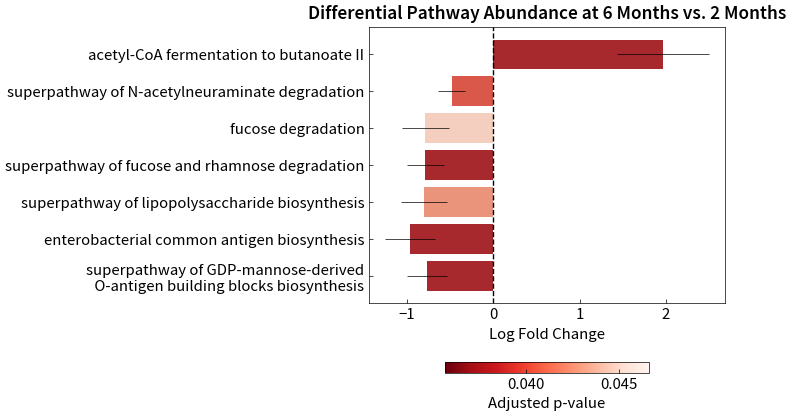

In [17]:
fig, ax = plt.subplots(1, 1, figsize=(7.5, 4.5))

plot_data = de_6months.loc[interesting_pathways, :]
plot_data.loc["PWY-7323", "description"] = "superpathway of GDP-mannose-derived\n O-antigen building blocks biosynthesis"

sns.barplot(
    data=plot_data,
    x="lfc",
    y="description",
    hue="q",
    palette="Reds_r",
    # hue="rich",
    # palette=["red", "blue"],
    dodge=False,
    ax=ax
)
ax.errorbar(
    x=plot_data["lfc"],
    y=range(len(plot_data)),
    xerr=plot_data["se"],
    fmt="none",
    ecolor="black",
    capsize=0,
    elinewidth=.5,
)
ax.axvline(0, color="black", linestyle="--", linewidth=1)

norm = plt.Normalize(plot_data.q.min(), plot_data.q.max())
sm = plt.cm.ScalarMappable(cmap="Reds_r", norm=norm)
ax.get_legend().remove()
ax.figure.colorbar(sm, ax=ax, label="Adjusted p-value", location="bottom", shrink=0.575,)


ax.set_xlabel("Log Fold Change")
ax.set_ylabel("")
ax.set_title("Differential Pathway Abundance at 6 Months vs. 2 Months")

fig.tight_layout()
fig.savefig("../figures/differential_pathway_abundance_6months_vs_2months.pdf")
fig.show()

### Implementation of GSEA

In order to group the pathways into more meaningful categories, we can take an approach from RNA-sequencing called gene set enrichement (GSEA). GSEA is a computational method that determines whether an a priori defined set of features shows statistically significant, concordant differences between two biological states. By aggregating information across sets of related features, it allows us to detect subtle but coordinated changes that might be missed when analyzing individual features in isolation. 

In our case, we compare the changes in pathway expression between the microbiome of 2 and 6 month old infants. In order to perform GSEA, we need a reference database that groups pathways into sets. [MetaCyc](https://metacyc.org/)-pathways all have ontology information included that gives higher level information about a pathway. E.g., the [acetyl-CoA fermentation to butanoate](https://metacyc.org/pathway?orgid=META&id=PWY-5676#ONT) pathway we have identified previously belongs to a set of pathways involved in fermentation. As I have not found a way to download the ontology database from MetaCyc (some form of subscription is required), we need to look elsewhere. Luckily, someone has curated some ontology information and made it available on [Github](https://github.com/Jiung-Wen/picrust_mapping). We will use the file mapping pathways to the secondary level of pathway ontology. I would have preferred some more detailed information, ideally level 3, but we will work with what we can get...

Normally, GSEA takes raw count data as the input and then calculates fold changes and p-values itself. As we have already done this with Ancombc2 (taking into account potential confounding effects) we don't want to do this again. 
After this step, the GSEA algorithm calculates a score for each gene or in this case, pathways, based on the fold change and adjusted p-value. The genes are then ordered by score. GSEA then takes these ranked genes and then calculates an enrichment score and p-value for each gene set. We can simply jump in by calculating the score ourselves and then use preranked GSEWA that is implemented in [GSEApy](https://gseapy.readthedocs.io/en/latest/introduction.html).

In [18]:
import gseapy as gp

# Download mapping file from Github
if not os.path.exists(f"{data_dir}/raw/metacyc_pathways2seclevel.txt"):
    subprocess.run(f"wget -O {data_dir}/raw/metacyc_pathways2seclevel.txt https://github.com/Jiung-Wen/picrust_mapping/raw/refs/heads/master/metacyc_pathways_info_prokaryotes_sec_level.tsv", shell=True)
else:
    print(f"{data_dir}/raw/metacyc_pathways2seclevel.txt already exists. Skipping download.")

pathways2seclevel = pd.read_csv(f"{data_dir}/raw/metacyc_pathways2seclevel.txt", sep="\t", header=None, names=["pathway", "seclevel"])

# We need to get the pathway sets in a form that gseapy can use
# Gseapy expects a dictionary where keys are the pathway set names (here: second level pathways)
# and values are lists of pathways belonging to that set
pathway_sets = pathways2seclevel.groupby("seclevel")["pathway"].apply(list).to_dict()

# Here we calculate the ranking metric for the pathways and sort them in descending order
pathway_rank = np.sign(de_6months["lfc"]) * (-1 * np.log10(de_6months["q"]))
pathway_rank = pathway_rank.sort_values(ascending=False)

../data/raw/metacyc_pathways2seclevel.txt already exists. Skipping download.


Here we perform pre-ranked GZL. We provide the ranked pathways and the pathway sets and also specify the minimun number of pathways need to be present in a pathway set to be included in the analysis. As our pathway sets are generally quite small compared to gene sets usually used in GSEA, we use a lower number, otherwise we would lose most pathway sets.

In [19]:
prerank_res = gp.prerank(
    rnk=pathway_rank,
    gene_sets=pathway_sets,
    min_size=2, # default is 15
    threads=4,
    outdir=None, # don't write to disk
    seed=1,
    verbose=True, # see what's going on behind the scenes
)

2025-12-18 23:06:16,846 [WARNING] Duplicated values found in preranked stats: 74.58% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


2025-12-18 23:06:16,847 [INFO] Parsing data files for GSEA.............................


2025-12-18 23:06:16,851 [INFO] 0064 gene_sets have been filtered out when max_size=500 and min_size=2


2025-12-18 23:06:16,851 [INFO] 0015 gene_sets used for further statistical testing.....


2025-12-18 23:06:16,851 [INFO] Start to run GSEA...Might take a while..................


2025-12-18 23:06:16,878 [INFO] Congratulations. GSEApy runs successfully................



In [20]:
print("Number of significant pathways sets found:", sum(prerank_res.res2d["FDR q-val"] < 0.05))

prerank_res.res2d.sort_values(by="FDR q-val")

Number of significant pathways sets found: 0


,Name,Term,ES,NES,NOM p-val,FDR q-val,FWER p-val,Tag %,Gene %,Lead_genes
0,prerank,Amine and Polyamine Degradation,-0.785714,-1.626119,0.046018,0.214768,0.222,3/3,27.12%,PWY0-41;PWY-5705;GLCMANNANAUT-PWY
1,prerank,Fatty Acid and Lipid Biosynthesis,0.549981,1.510698,0.09009,0.543037,0.42,4/5,28.81%,LPSSYN-PWY;PWYG-321;PWY-5989;PWY-6282
10,prerank,TCA cycle,-0.526316,-0.966995,0.490196,0.566773,0.999,2/2,50.85%,TCA-GLYOX-BYPASS;P105-PWY
4,prerank,Secondary Metabolite Degradation,-0.380956,-1.205445,0.213115,0.579546,0.93,5/8,32.20%,P562-PWY;PWY-7237;GALACTARDEG-PWY;KETOGLUCONME...
8,prerank,Inorganic Nutrient Metabolism,-0.561404,-1.005209,0.467836,0.619529,0.995,2/2,47.46%,SO4ASSIM-PWY;SULFATE-CYS-PWY
9,prerank,Fermentation,0.54386,0.978978,0.451613,0.724199,0.999,2/2,47.46%,PWY-5676;P461-PWY
7,prerank,"Cofactor, Prosthetic Group, Electron Carrier, ...",-0.296678,-1.026949,0.399312,0.734978,0.992,9/10,67.80%,PWY-5855;PWY-5856;UBISYN-PWY;PWY-6708;PWY-5857...
12,prerank,Amino Acid Biosynthesis,0.392857,0.849147,0.668605,0.739458,1.0,3/3,62.71%,PWY-5345;PWY0-1061;PWY-5154
6,prerank,Carbohydrate Degradation,0.487675,1.054506,0.37827,0.751854,0.987,2/3,18.64%,FUCCAT-PWY;RHAMCAT-PWY
2,prerank,Carboxylate Degradation,0.701754,1.276711,0.207921,0.770889,0.809,2/2,32.20%,PWY-5747;P441-PWY


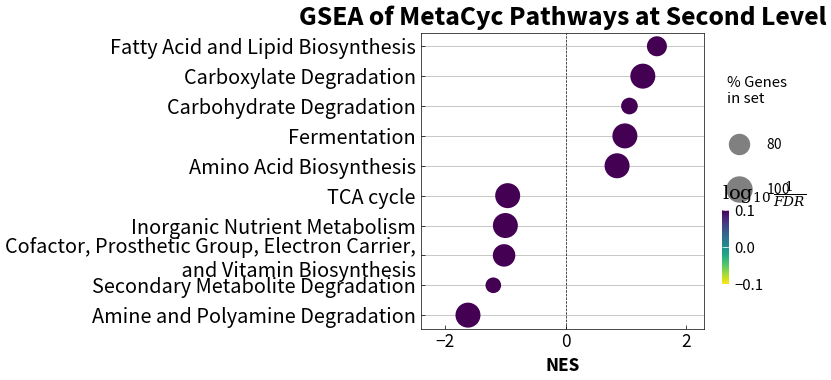

In [21]:
fig, ax = plt.subplots(1, 1, figsize=(8, 4))

prerank_res.res2d.loc[
    prerank_res.res2d["Term"] == "Cofactor, Prosthetic Group, Electron Carrier, and Vitamin Biosynthesis",
    "Term"
] = "Cofactor, Prosthetic Group, Electron Carrier,\n and Vitamin Biosynthesis"
gp.dotplot(
    prerank_res.res2d,
    title="GSEA of MetaCyc Pathways at Second Level",
    column="FDR q-val",
    top_term=10,
    size=3, # adjust dot size
    figsize=(8,4), cutoff=1, show_ring=False,
    ax=ax
)
ax.axvline(x=0, color='black', linestyle='--', linewidth=.5)

fig.tight_layout()
fig.savefig("../figures/gsea_metacyc_pathways_second_level.pdf")

As can be seen in the results, no pathway sets are significantly enriched or depleted between the two time points. This contrasts the observations we have made when only comparing individual pathways. This may be due to the fact that the pathway sets we use in this analysis are very high-level and therefore have low resolution. Only a few pathways in these sets show differential abundance, but these individual effects are covered up by the sheer numbers of pathways in some of the sets. We would have preferred to work with more detailed information, ideally level 3, but this data was not available to us.

## Feature volatility

Another option to investigate changes is computing feature volatility which is exposed in the longitudinal plugin in QIIME.
TOOD: either fix or delete

In [22]:
if not os.path.exists(f"{data_dir}/processed/feature_volatility_pathway_abundance"):
    ! qiime longitudinal feature-volatility \
        --i-table $picrust_results_dir/pathway_abundance.qza \
        --m-metadata-file $data_dir/raw/metadata_numeric_timepoints.tsv \
        --p-state-column "timepoint" \
        --p-individual-id-column "infant_id" \
        --p-random-state 2025 \
        --p-n-jobs $num_cpus \
        --p-n-estimators 1000 \
        --p-parameter-tuning \
        --p-missing-samples "ignore" \
        --output-dir $data_dir/processed/feature_volatility_pathway_abundance
else:
    print(f"{data_dir}/processed/feature_volatility_pathway_abundance already exists. Skipping computation.")

/cluster/home/fschindele/miniconda3/envs/microbEvolve/lib/python3.10/site-packages/q2_demux/_summarize/_visualizer.py:11: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


Saved FeatureTable[RelativeFrequency] to: ../data/processed/feature_volatility_pathway_abundance/filtered_table.qza
Saved FeatureData[Importance] to: ../data/processed/feature_volatility_pathway_abundance/feature_importance.qza


Saved Visualization to: ../data/processed/feature_volatility_pathway_abundance/volatility_plot.qzv


Saved Visualization to: ../data/processed/feature_volatility_pathway_abundance/accuracy_results.qzv


Saved SampleEstimator[Regressor] to: ../data/processed/feature_volatility_pathway_abundance/sample_estimator.qza


In [23]:
if not os.path.exists(f"{data_dir}/processed/feature_volatility_ec_metagenome"):
    ! qiime longitudinal feature-volatility \
        --i-table $picrust_results_dir/ec_metagenome.qza \
        --m-metadata-file $data_dir/raw/metadata_numeric_timepoints.tsv \
        --p-state-column "timepoint" \
        --p-individual-id-column "infant_id" \
        --p-random-state 2025 \
        --p-n-jobs $num_cpus \
        --p-n-estimators 1000 \
        --p-parameter-tuning \
        --p-missing-samples "ignore" \
        --output-dir $data_dir/processed/feature_volatility_ec_metagenome
else:
    print("Feature volatility results already exist. Skipping computation.")

/cluster/home/fschindele/miniconda3/envs/microbEvolve/lib/python3.10/site-packages/q2_demux/_summarize/_visualizer.py:11: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


Saved FeatureTable[RelativeFrequency] to: ../data/processed/feature_volatility_ec_metagenome/filtered_table.qza
Saved FeatureData[Importance] to: ../data/processed/feature_volatility_ec_metagenome/feature_importance.qza


Saved Visualization to: ../data/processed/feature_volatility_ec_metagenome/volatility_plot.qzv
Saved Visualization to: ../data/processed/feature_volatility_ec_metagenome/accuracy_results.qzv


Saved SampleEstimator[Regressor] to: ../data/processed/feature_volatility_ec_metagenome/sample_estimator.qza
